# Добро пожаловать в мой проект по разведочному анализу и визуализации данных!

Здесь я делюсь своим опытом анализа интересного датасета по Spotify. Этот проект — моя возможность углубиться в разведочный анализ данных (EDA) и освоить различные методы визуализации. Цель не только в практике и обнаружении закономерностей и фактов, скрытых в данных, но и в построении моделей - причем при моделировании были также привлечены реальные люди - для того чтобы убедиться в валидности данных.

Буду очень рада обратной связи и любым советам и приятного просмотра!

**ВАЖНО**

Код выполнен в `Google Colab`, поэтому некоторые графики, выполненные с помощью библиотеки `plotly`, могут не отображаться в `Jupiter Notebook`

# Анализ данных

Данные были предварительно обработаны перед моделированием. Сначала в Microsoft Excel были выполнены следующие действия по очистке данных:

* Удаление строк с заголовками
* Удаление дубликатов на основе track_id

Затем был создан объединенный CSV-файл, с которым и производится дальнейшая работа.


In [2]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import datetime as dt

import matplotlib
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
init_notebook_mode(connected=True)

In [4]:
# загружаем данные
playlists = pd.read_csv('dataset.csv')
print(playlists.head(5))

   Unnamed: 0                album_id                                         album_name  year_released album_release_date            track_artist_ids                track_id  track_duration_ms  track_explicit                                         track_name  track_popularity  danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo       audio_features_id              artist1_id  followers  artist_popularity artist_genre1 artist_genre2 artist_genre3              album_label  album_popularity  in_playlist
0        3325  671JMBwDOqsTqgUQ1uV31Q  Album for the Young: Gentle Piano by Tchaikovs...              5          3/29/2014  ['4tSF3kfKHwrJHGS7B4UPoK']  0deYxSSsBtn2F4Al1Sj5by              71523           False  Album for the Young, Op. 68 "Album für die Jug...                 0         0.719  0.0579  7.0   -14.153   1.0       0.3310         0.996             0.922    0.1010    0.724   74.162  0deYxSSsBtn2F4Al1Sj5by  4tSF3kfKH

## Первичный анализ данных

In [6]:
playlists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32054 entries, 0 to 32053
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          32054 non-null  int64  
 1   album_id            32054 non-null  object 
 2   album_name          32052 non-null  object 
 3   year_released       32054 non-null  int64  
 4   album_release_date  32054 non-null  object 
 5   track_artist_ids    32054 non-null  object 
 6   track_id            32054 non-null  object 
 7   track_duration_ms   32054 non-null  int64  
 8   track_explicit      32054 non-null  bool   
 9   track_name          32051 non-null  object 
 10  track_popularity    32054 non-null  int64  
 11  danceability        32051 non-null  float64
 12  energy              32051 non-null  float64
 13  key                 32051 non-null  float64
 14  loudness            32051 non-null  float64
 15  mode                32051 non-null  float64
 16  spee

In [7]:
playlists.describe()

Unnamed: 0  year_released  track_duration_ms  track_popularity  danceability        energy           key      loudness          mode   speechiness  acousticness  instrumentalness      liveness       valence         tempo     followers  artist_popularity  album_popularity   in_playlist
count  32054.000000    32054.00000       3.205400e+04      32054.000000  32051.000000  32051.000000  32051.000000  32051.000000  32051.000000  32051.000000  32051.000000      32051.000000  32051.000000  32051.000000  32051.000000  3.205300e+04       32053.000000      32051.000000  32054.000000
mean    1379.720347        4.88691       2.331788e+05         47.303831      0.603822      0.645656      5.172881     -7.298922      0.666687      0.096762      0.240137          0.067038      0.190256      0.488044    121.930346  2.547067e+06          64.210121         51.072447      0.086760
std      926.423713        0.33676       6.789242e+04         20.058699      0.161593      0.209816      3.591492      3.591367      0.471405      0.113947      0.282773          0.206164      0.159741      0.242514     28.602712  4.589286e+06          17.617840         19.672425      0.281487
min        0.000000        1.00000       6.000000e+03          0.000000      0.000000      0.000000      0.000000    -60.000000      0.000000      0.000000      0.000000          0.000000      0.000000      0.000000      0.000000  0.000000e+00           0.000000          0.000000      0.000000
25%      616.000000        5.00000       1.976400e+05         35.000000      0.495000      0.512000      2.000000     -8.762000      0.000000      0.035500      0.021400          0.000000      0.094100      0.294000     99.978000  1.255440e+05          55.000000         40.000000      0.000000
50%     1252.000000        5.00000       2.249460e+05         51.000000      0.612000      0.674000      5.000000     -6.488000      1.000000      0.050400      0.111000          0.000004      0.125000      0.478000    121.006000  7.203150e+05          67.000000         54.000000      0.000000
75%     1982.000000        5.00000       2.591020e+05         63.000000      0.722000      0.810000      8.000000     -4.915000      1.000000      0.102000      0.379000          0.001180      0.241000      0.679000    139.985000  2.888672e+06          77.000000         66.000000      0.000000
max     4001.000000        7.00000       3.012273e+06         93.000000      0.988000      0.999000     11.000000      2.427000      1.000000      0.965000      0.996000          0.999000      0.993000      0.990000    232.080000  3.003438e+07         100.000000         94.000000      1.000000

In [8]:
playlists.describe(include=['O'])

album_id     album_name album_release_date            track_artist_ids                track_id track_name       audio_features_id              artist1_id artist_genre1 artist_genre2 artist_genre3            album_label
count                    32054          32052              32054                       32054                   32054      32051                   32051                   32053         30153         26944         23915                  32042
unique                   11390          10749               3321                        8618                   19167      17301                   19164                    5933           593           567           476                   3637
top     09Q3WwGYsQe5ognkvVkmCu  Greatest Hits           1/1/2013  ['0hEurMDQu99nJRq8pTxO14']  4WjH9Bzt3kx7z8kl0awxh4     Closer  4WjH9Bzt3kx7z8kl0awxh4  3TVXtAsR1Inumwj472S9r4     dance pop           pop           pop  Universal Music Group
freq                        75             82                908                         224                      12         24                      12                     293          4130          3148          2763                   2775

Тепловая карта визуализирует пропущенные значения в наборе данных. Белый цвет обозначает отсутствие пропусков, а оттенки зеленого — их наличие. Это позволяет быстро определить признаки с большим количеством пропусков, требующие обработки или исключения из анализа.

<Axes: >

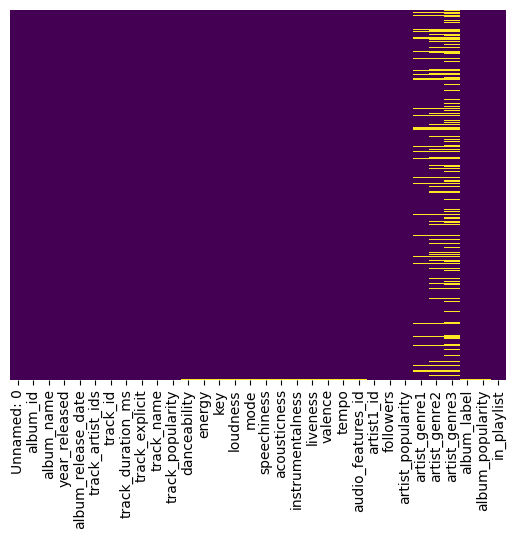

In [9]:
sns.heatmap(playlists.isnull(), yticklabels=False, cbar=False, cmap='viridis')

На графике выделены нулевые значения желтым. В столбцах с жанрами есть пустые значения, которые указывают на отсутствие информации или сбора данных. Они будут убраны в секции Feature Selection.

## Визуализация данных

In [10]:
def custom_hist(training_set, title,  xlabel, ylabel='Количество', bins=None):
    figsize = (20,6)
    plt.figure(figsize=figsize)
    plt.grid(True)
    plt.title(title)

    # Проверить тип данных training_set
    if training_set.dtype == bool:
        # Для булевых данных использовать только два значения (0 и 1)
        bins = [0, 1]
    elif training_set.dtype == np.int64 or training_set.dtype == np.float64:
        # Для целых и вещественных чисел использовать либо заданные интервалы, либо автоматическое определение интервалов
        bins = training_set.max().astype(int) if bins is None else bins
    else:
        # Для категориальных данных использовать автоматическое определение интервалов
        bins = None

    plt.hist(training_set, bins)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [11]:
columns_to_look = ['year_released', 'track_explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'artist_popularity', 'album_popularity', 'in_playlist']

fig1 = make_subplots(
    rows=3, cols=2,
    subplot_titles=columns_to_look[:6]
)

row_col_map1 = {
    'year_released': (1, 1),
    'track_explicit': (1, 2),
    'danceability': (2, 1),
    'energy': (2, 2),
    'key': (3, 1),
    'loudness': (3, 2),
}

for column in columns_to_look[:6]:
    fig1.add_trace(go.Histogram(x=playlists[column], name=column), row=row_col_map1[column][0], col=row_col_map1[column][1])

fig1.update_layout(
    title_text='<b>Feature Distribution (Part 1)</b>',
    template='plotly_dark',
    title_x=0.5,
    height=800
)
fig1.show(renderer='colab')

График выше, первый из 3, визуализирует распределение признаков треков.
Большинство треков выпущены в 5-м году, меньшая часть в 4-м и 6-м, остальные годы представлены незначительно.
Треки с явным контентом составляют меньшинство.
Распределение танцевальности следует нормальному распределению с пиком около 0,6, указывая на средний уровень.
Энергичность треков постепенно растет с пиком в диапазоне 0,6-0,8, указывая на высокий уровень энергии.
Ключи треков распределены равномерно, отражая разнообразие тональностей.
Громкость показывает скошенное распределение с пиком в диапазоне от -10 до 0 дБ, указывая на преобладание треков с этой громкостью.

In [12]:
fig2 = make_subplots(
    rows=3, cols=2,
    subplot_titles=columns_to_look[6:12]
)

row_col_map2 = {
    'mode': (1, 1),
    'speechiness': (1, 2),
    'acousticness': (2, 1),
    'instrumentalness': (2, 2),
    'liveness': (3, 1),
    'valence': (3, 2),
}

for column in columns_to_look[6:12]:
    fig2.add_trace(go.Histogram(x=playlists[column], name=column), row=row_col_map2[column][0], col=row_col_map2[column][1])

fig2.update_layout(
    title_text='<b>Feature Distribution (Part 2)</b>',
    template='plotly_dark',
    title_x=0.5,
    height=800)
fig2.show(renderer='colab')

Распределение признаков:

• Mode: сбалансированное количество треков в мажорном и минорном ладах.

• Speechiness: равномерное распределение с разнообразием речевых компонентов.

• Acousticness: широкий диапазон от акустических до электронных треков.

• Instrumentalness: равномерное распределение вокальных и инструментальных треков.

• Liveness: умеренное распределение без явных пиков.

• Valence: равномерное распределение от меланхоличных до жизнерадостных треков.

In [13]:
fig3 = make_subplots(
    rows=3, cols=2,
    subplot_titles=columns_to_look[12:]
)

row_col_map3 = {
    'tempo': (1, 1),
    'followers': (1, 2),
    'artist_popularity': (2, 1),
    'album_popularity': (2, 2),
    'in_playlist': (3, 1),
}

for column in columns_to_look[12:]:
    fig3.add_trace(go.Histogram(x=playlists[column], name=column), row=row_col_map3[column][0], col=row_col_map3[column][1])

fig3.update_layout(
    title_text='<b>Feature Distribution (Part 3)</b>',
    template='plotly_dark',
    title_x=0.5,
    height=800
)
fig3.show(renderer='colab')

• Tempo: равномерное, с небольшим пиком в начале (разнообразие темпов).
• Followers: тенденция к увеличению (большее количество подписчиков у некоторых исполнителей).
• Artist popularity: восходящий тренд (треки популярных исполнителей).
• Album popularity: восходящий тренд (треки из популярных альбомов).
• In playlist: почти равномерное распределение (треки включены в плейлисты или нет).

Визуализации показывают, что все переменные более менее равномерно распределены, следовательно нельзя сделать вывод об удалении признаков или аномальных значениях

In [14]:
fig = px.box(playlists,
       x='track_explicit',
       y='track_popularity',
       color='track_explicit',
       template='plotly_dark',
       color_discrete_sequence=['cyan','magenta'],
       title='<b>popularity based on explicit content')
fig.update_layout(title_x=0.5)
fig.show(renderer='colab')

Заметим что несмотря на то что в распределении мы видели что цензурных песен сильно больше чем нецензурных, они менее популярные

In [15]:
fig = px.box(playlists,
       x='in_playlist',
       y='track_popularity',
       color='in_playlist',
       template='plotly_dark',
       color_discrete_sequence=['cyan','magenta'],
       title='<b>popularity based on playlist content')
fig.update_layout(title_x=0.5)
fig.show(renderer='colab')

Песен вне плейлиста больше чем песен внутри плейлиста, и они популярнее

In [16]:
columns_to_look = ['year_released', 'track_explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'artist_popularity', 'album_popularity', 'in_playlist']
dist = playlists.copy()

# Пример функции для биннинга колонок
def bin_column(column):
    return pd.cut(column, bins=70, labels=False)

for column in columns_to_look:
    if column in ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'artist_popularity', 'album_popularity']:
        dist[column] = bin_column(dist[column])

fig1 = make_subplots(
    rows=3, cols=2,
    subplot_titles=columns_to_look[:6]
)

row_col_map1 = {
    'year_released': (1, 1),
    'track_explicit': (1, 2),
    'danceability': (2, 1),
    'energy': (2, 2),
    'key': (3, 1),
    'loudness': (3, 2),
}

for column in columns_to_look[:6]:
    pivot = dist.pivot_table(index=column, values='track_popularity', aggfunc='mean').reset_index()
    row, col = row_col_map1[column]
    fig1.add_trace(go.Bar(x=pivot[column], y=pivot['track_popularity'], name=column), row=row, col=col)

fig1.update_layout(title_text='<b>Популярность по признакам (Part 1)</b>', template='plotly_dark', title_x=0.5, height=800)
fig1.show(renderer='colab')


In [17]:
fig2 = make_subplots(
    rows=3, cols=2,
    subplot_titles=columns_to_look[6:12]
)

row_col_map2 = {
    'mode': (1, 1),
    'speechiness': (1, 2),
    'acousticness': (2, 1),
    'instrumentalness': (2, 2),
    'liveness': (3, 1),
    'valence': (3, 2),
}

for column in columns_to_look[6:12]:
    pivot = dist.pivot_table(index=column, values='track_popularity', aggfunc='mean').reset_index()
    row, col = row_col_map2[column]
    fig2.add_trace(go.Bar(x=pivot[column], y=pivot['track_popularity'], name=column), row=row, col=col)

fig2.update_layout(title_text='<b> Популярность по признакам (Part 2)</b>', template='plotly_dark', title_x=0.5, height=800)
fig2.show(renderer='colab')

In [18]:
fig3 = make_subplots(
    rows=3, cols=2,
    subplot_titles=columns_to_look[12:]
)

row_col_map3 = {
    'tempo': (1, 1),
    'followers': (1, 2),
    'artist_popularity': (2, 1),
    'album_popularity': (2, 2),
    'in_playlist': (3, 1),
}

for column in columns_to_look[12:]:
    pivot = dist.pivot_table(index=column, values='track_popularity', aggfunc='mean').reset_index()
    row, col = row_col_map3[column]
    fig3.add_trace(go.Bar(x=pivot[column], y=pivot['track_popularity'], name=column), row=row, col=col)

fig3.update_layout(title_text='<b>Популярность по признакам (Part 3)</b>', template='plotly_dark', title_x=0.5, height=800)
fig3.show(renderer='colab')

Видим, что ни один из признаков не стоит убирать из таблицы, т.к. значения популярности отличается.  То есть удалить эти признаки мы всё-таки не можем, т.к. значения доли различны.

Теперь можем просто "поиграться" с данными - и это также поможет нам узнать чуть больше о признаках трека по отдельности, и также в отношении других признаков.




In [21]:
# Сортировка данных
df_sorted = playlists.sort_values(by='track_popularity', ascending=False)

# Выбор топ самых прослушиваемых песен для упрощения визуализации
top_songs = df_sorted.head(10)

# Создание горизонтального столбчатого графика
fig = px.bar(top_songs, x='track_popularity', y='track_name',
             title='Топ 10 самых популярных песен',
             labels={'track_popularity': 'Популярность', 'track_name': 'Песня'},
             color='track_popularity', text='track_popularity', height=600)

# Улучшение визуального отображения: изменение порядка данных на графике
fig.update_layout(yaxis={'categoryorder':'total ascending'})

# Показать график
fig.show(renderer='colab')

In [22]:
fig=px.pie(playlists.groupby('track_explicit',as_index=False).count().sort_values(by='track_name',ascending=False),
           names='track_explicit',
           values='track_name',
           labels={'track_name':'Total songs'},
           hole=.6,
           color_discrete_sequence=['#237f52','#e32636'],
           template='plotly_dark',title='<b>Songs having explicit content')
fig.update_layout(title_x=0.5)
fig.show(renderer='colab')

In [23]:
fig = px.scatter(playlists,
           x='danceability',
           y='track_popularity',
           color='danceability',
           color_continuous_scale=px.colors.sequential.Plasma,
           template='plotly_dark',
           title='<b>Корреляция между Danceability и Popularity')
fig.update_layout(title_x=0.5)
fig.show(renderer='colab')

In [24]:
fig = px.scatter(playlists,
           x='speechiness',
           y='track_popularity',
           color='speechiness',
           color_continuous_scale=px.colors.sequential.Plasma,
           template='plotly_dark',
           title='<b>Корреляция между Speechiness и Popularity')
fig.update_layout(title_x=0.5)
fig.show(renderer='colab')

In [ ]:
fig = px.scatter(playlists,
           x='energy',
           y='danceability',
           color='danceability',
           color_continuous_scale=px.colors.sequential.Plotly3,
           template='plotly_dark',
           title='<b>Корреляция между Energy и Danceability')
fig.update_layout(title_x=0.5)
fig.show(renderer='colab')

In [ ]:
fig = px.scatter(playlists, x="acousticness", y="track_popularity", template='plotly_dark', color = 'acousticness',
                  title="<b> Корреляция между Popularity и Acousticness")
fig.update_layout(title_x=0.5)
fig.show(renderer='colab')

Диаграммы рассеяния были построены для изучения взаимосвязей между различными парами признаков. Анализ диаграмм рассеяния позволяет визуально оценить наличие и направление корреляции между признаками. Однако построенные диаграммы не выявили явной корреляции между признаками, что указывает на отсутствие мультиколлинеарности.

Отсутствие мультиколлинеарности является благоприятным результатом для построения моделей машинного обучения и статистического анализа. Это означает, что каждый признак вносит независимый вклад в модель, и ни один признак не является избыточным. Это приводит к более надежным, интерпретируемым и устойчивым моделям.

In [ ]:
fig = px.scatter(playlists,
           x='energy',
           y='loudness',
           color='energy',
           template='plotly_dark',
           title='<b>Корреляция между Energy и Loudness')
fig.update_layout(title_x=0.5)
fig.show(renderer='colab')

Обнаруженная корреляция между признаками energy и loudness в ходе построения диаграмм рассеяния по парам признаков требует внимания на этапе выбора признаков (feature selection). Мультиколлинеарность между этими признаками может привести к проблемам при построении моделей машинного обучения и статистическом анализе.

In [ ]:
df = playlists.drop(['Unnamed: 0','album_id', 'track_artist_ids', 'audio_features_id', 'artist1_id', 'album_label','year_released', 'track_id'], axis=1)

In [ ]:
# создание нового датафрейма без признаков которые сложно будет перевести в числовые или ненужные для модели
X_database = playlists.drop(['Unnamed: 0','album_id', 'album_name', 'album_release_date', 'track_artist_ids', 'track_name', 'audio_features_id', 'artist1_id', 'artist_genre1', 'artist_genre2', 'artist_genre3', 'album_label','year_released'], axis=1)

In [ ]:
X_database = X_database.dropna(axis=0)
X_database.shape

(32051, 19)

In [ ]:
# сделаем копию так как сейчас будут удалены признаки которые позже будут нужны
X_database_main = X_database.copy()

# удаление бинарных признаков и ID
del X_database["track_explicit"]
del X_database["mode"]
del X_database["in_playlist"]
del X_database['track_id']
# стандартизирование всех количественных признаков
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_database)
X_database_scaled = scaler.transform(X_database)
X_database_scaled = pd.DataFrame(X_database_scaled)
X_database_scaled.columns = X_database.columns

# возвращение бинарных признаков и ID
X_database_scaled["track_explicit"] = X_database_main["track_explicit"]
X_database_scaled["mode"] = X_database_main["mode"]
X_database_scaled["in_playlist"] = X_database_main["in_playlist"]

In [ ]:
X_database_scaled.head()

track_duration_ms  track_popularity  danceability    energy       key  loudness  speechiness  acousticness  instrumentalness  liveness   valence     tempo  followers  artist_popularity  album_popularity  track_explicit  mode  in_playlist
0          -2.381157         -2.358229      0.712777 -2.801331  0.508743 -1.908517     2.055703      2.673083          4.147056 -0.558762  0.972975 -1.670090  -0.555003          -2.566291         -2.596184           False   1.0            1
1           1.133484         -1.909557     -1.781186 -3.000556  1.065624 -6.857963    -0.155880      2.673083          4.205263 -0.408516 -1.402183  2.033079  -0.554974          -2.339242         -1.528684           False   0.0            1
2          -1.585774          1.031731     -0.283571 -2.953848  0.787183 -6.325566    -0.447248      2.673083          3.899677 -0.584429 -0.486758  1.254469  -0.475669          -0.182280          0.555484           False   1.0            1
3           0.315446         -2.009262     -0.110293 -2.405265  1.065624 -3.916419    -0.212925      2.673083          4.219815 -0.546241 -0.453769 -1.717988  -0.554686          -2.736577         -2.494518           False   1.0            1
4          -2.128138         -1.062068     -0.345456 -3.011518 -0.605017 -6.835130    -0.537642      2.673083          3.797815 -0.533721 -1.158894 -1.607402  -0.554573          -1.544572         -0.918683           False   1.0            1

Давайте проверим что нет дубликатов по `track_id`

In [ ]:
len(playlists['track_id'].unique()), len(playlists)

(19167, 32054)

In [ ]:
playlists = playlists.drop_duplicates(subset=['track_id'], ignore_index=True)

## Feature Engineering

In [ ]:
# Изменяем album_release_date к формату ГГГГ
import re
bad_indices = [] # туда попадут треки которые не попадают в следующие категории:

lst_4_years = [] # ГГГГ
lst_2_slash = [] # ММ/ДД/ГГ
lst_2_hyphen = [] # ГГГГ-ММ

lst_year_release = [] # тут будут года которые мы конвертировали в формат ГГГГ

for i, date in enumerate(playlists.album_release_date):

    if len(date)==4: # ничего не меняем, ГГГГ
        lst_4_years.append(date)
        lst_year_release.append(date)

    elif re.findall(r"(.){1,2}[/](.){1,2}[/](.){1,2}",date): # конвертирование в ММ/ДД/ГГ
        lst_2_slash.append(date)

        if int(date[-2:]) < 19: # для годов  начиная с 2000
            lst_year_release.append("20"+(date[-2:]))
        else:
            lst_year_release.append("19"+(date[-2:])) # для годов до 2000 года

    elif re.findall(r"(.){4}-(.){2}",date): # конвертирование в ГГГГ/ММ
        lst_2_hyphen.append(date)
        lst_year_release.append(date[:4])

    else:
        bad_indices.append((i, date))

print(len(bad_indices))
playlists["release_year"] = lst_year_release

0


Нет элементов в массиве в которые должны попадать года других форматов, значит все форматы в датафрейме были учтены и конвертированы корректно

In [ ]:
# проверка, что не может быть ситуации где перепутают ММ/ДД/1918 и ММ/ДД/2018 за одну дату
print(sorted(set(lst_year_release)))

['1939', '1942', '1945', '1947', '1948', '1949', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']


Самая ранняя дата - 1939 - никак не могла пересечься последними двумя цифрами даже с самой поздней - 2018

## Feature selection

<Axes: >

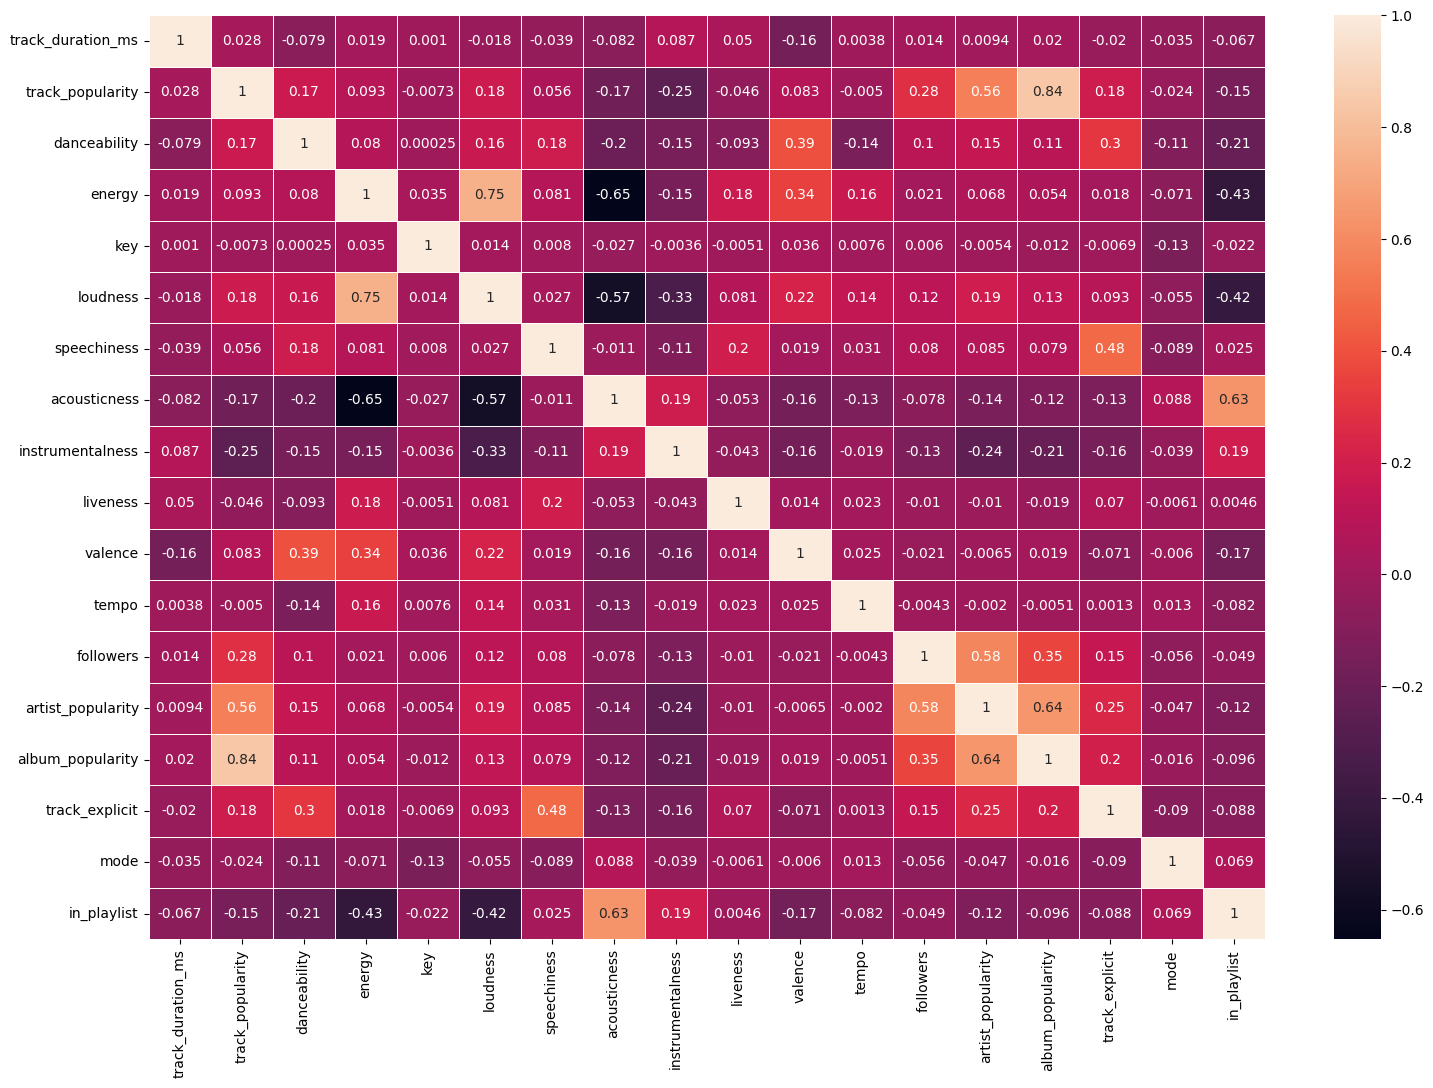

In [ ]:
# построение тепловой карты получившегося датафрейма
import seaborn as sns

plt.subplots(figsize=(18, 12))
corr = X_database_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5,annot=True)

Исходя из графика корреляции, можно отбросить одну из всех пар признаков, у которых корреляция превышает 0,75. Это необходимо для того, чтобы при подгонке регрессионной модели веса/коэффициенты двух почти коллинеарных признаков не были распределены произвольно, что испортит интерпретируемость обоих признаков.

Пары, которые отвечают этим критериям, - это loudness и energy, а также album_popularity и track_popularity. Такие высокие корреляции имеют смысл, и оба признака в каждой паре, вероятно, не должны входить в одну модель с точки зрения логики.

Можно решить, какой из них отбросить, основываясь на их следующей по величине корреляции с другим признаком, то есть можно отбросить энергию вместо громкости, потому что energy сильнее коррелирует с acousticness, и можно отбросить album_popularity вместо track_popularity, потому что album_popularity сильнее коррелирует с artist_popularity.

In [ ]:
del X_database_scaled['energy']
del X_database_scaled['album_popularity']
X_database_scaled["track_id"] = X_database_main["track_id"]

# Построение моделей

## Построение моделей на основе оценок участников запроса

Для огромного набора данных Spotify было сложно разработать единую модель данных. Были испытаны два основных подхода для решения проблемы и генерации рекомендаций. Первый основан на системе оценок пользователей: трое пользователей оценивали случайные песни (20 штук) по шкале от 1 до 10, что позволило обучить модель предсказывать их предпочтения и выдавать список из 10 лучших песен. Второй подход учитывал песни из плейлистов пользователей, но из-за ограниченности базы данных его нельзя было протестировать на реальных пользователях.

В приведенной ниже ячейке сгенерировано 20 случайных идентификаторов треков, чтобы раздать их трем испытуемым: Якут, Руфина и Анна. Распечатана соответствующая открытая ссылка Spotify, испытуемых попросили прослушать треки полностью.

Каждый из них выставил оценки от 1 до 10, с возможностью проставления с
десятичными знаками, для каждой песни.

In [ ]:
# # # DO NOT RUN AGAIN
# indices = np.arange(X_database_scaled.shape[0])

# random_indices = np.random.choice(indices, size=20, replace=False)
# random_indices2 = np.random.choice(indices, size=20, replace=False)
# random_indices3 = np.random.choice(indices, size=20, replace=False)

# yakut = []
# rufina = []
# anna = []
# # ПЕСНИ ДЛЯ ЯКУТ
# yakut_X = X_database_scaled.loc[random_indices]
# yakut_X.head(1)
# for id in yakut_X.track_id:
#     yakut.append('https://open.spotify.com/track/{}'.format(id))

# # ПЕСНИ ДЛЯ РУФИНЫ
# rufina_X = X_database_scaled.loc[random_indices2]
# for id in rufina_X.track_id:
#     rufina.append('https://open.spotify.com/track/{}'.format(id))

# # # ПЕСНИ ДЛЯ АННЫ
# anna_X = X_database_scaled.loc[random_indices3]
# for id in anna_X.track_id:
#     anna.append('https://open.spotify.com/track/{}'.format(id))

In [ ]:
yakut = ['https://open.spotify.com/track/5lFdf6lKl6zRRexbRZ3MP5',
 'https://open.spotify.com/track/6rh7tCci9IVYbEvLwLuXgz',
 'https://open.spotify.com/track/63C0qRVble3EdVf6NrAihE',
 'https://open.spotify.com/track/7efTNoBgYZ3IsB8wpP1f7R',
 'https://open.spotify.com/track/4LloVtxNZpeh7q7xdi1DQc',
 'https://open.spotify.com/track/5deDWZeDHWfYk9xaq9ynh4',
 'https://open.spotify.com/track/2mWkRDojGUDop9Il4212M0',
 'https://open.spotify.com/track/19V67jrPI3SBy4dVksrsoH',
 'https://open.spotify.com/track/6cJLfIqwh0tCKRjYM3WpZ5',
 'https://open.spotify.com/track/47E5PZDMp6Wsg4S8wakGQZ',
 'https://open.spotify.com/track/2xyi5jBkaQ741tXWTiqyr0',
 'https://open.spotify.com/track/3FRRgKEg2CK20D0ElLBioS',
 'https://open.spotify.com/track/5ztCcMNmFiq5ZnID9jY9SP',
 'https://open.spotify.com/track/7vidktgNZFQylTgH1GEnMs',
 'https://open.spotify.com/track/22v9ZVkWWAYjderL7ZWuuH',
 'https://open.spotify.com/track/6sPOmDulFtLzfX25zICNrC',
 'https://open.spotify.com/track/4JYyMs7TpnRXmXvRi1XhXy',
 'https://open.spotify.com/track/2TjnCxxQRYn56Ye8gkUKiW',
 'https://open.spotify.com/track/40EDOraCqoiMf14TzODihf',
 'https://open.spotify.com/track/5aahAvbdNGcaDH0osSgjMp']

In [ ]:
rufina = ['https://open.spotify.com/track/444P4wvSDa0SD5HE4YGx9B',
 'https://open.spotify.com/track/6REbwUNlppTfcnV4d4ZoZi',
 'https://open.spotify.com/track/1XTnPmn40BpRCJQ6ftgaL8',
 'https://open.spotify.com/track/0Q3SC6kEhxYagDP3bFe5K9',
 'https://open.spotify.com/track/6qxiDi8ZFZDeHANbP6URx5',
 'https://open.spotify.com/track/6kp8F9FpHXzjga2MeRDSG8',
 'https://open.spotify.com/track/5nN8BwAQDJDguq7Dpd3JQQ',
 'https://open.spotify.com/track/19gEmPjfqSZT0ulDRfjl0m',
 'https://open.spotify.com/track/4r0GVpjSsKSR1biv4fOoa5',
 'https://open.spotify.com/track/6svZ9rs70wvsCWacMHgzPM',
 'https://open.spotify.com/track/08Pzeh9Z5xZCe6UVK7nlHf',
 'https://open.spotify.com/track/6Dcc2Qt1yoBAsxL5qFm7RQ',
 'https://open.spotify.com/track/2mk87j3RWPdzy0rWIoUP1o',
 'https://open.spotify.com/track/4aWmUDTfIPGksMNLV2rQP2',
 'https://open.spotify.com/track/5R4HqXCZ6uTjxxnGdLt2S6',
 'https://open.spotify.com/track/0ERbK7qVqveCaBWIiYCrl3',
 'https://open.spotify.com/track/5ojttxoXyxwaAPMMm9AOFG',
 'https://open.spotify.com/track/0w3tfFeIEciVlOyxWQMR9G',
 'https://open.spotify.com/track/53Pgsvu3qSYO2aXt5J2vcL',
 'https://open.spotify.com/track/7Lf7oSEVdzZqTA0kEDSlS5']

In [ ]:
anna = ['https://open.spotify.com/track/6N4726teE6cayug44bb9a4',
 'https://open.spotify.com/track/1PrifAq8c7ONm9oB6XIgSS',
 'https://open.spotify.com/track/2t23OpNrcv1J9qsVzc7ao0',
 'https://open.spotify.com/track/79lAi6ZeFt9Wsn4GyD6IaZ',
 'https://open.spotify.com/track/3fDsErbmOD3TuaSDuxSXav',
 'https://open.spotify.com/track/74oHrNyQAbrr5uYW5UxBsQ',
 'https://open.spotify.com/track/3bC1ahPIYt1btJzSSEyyrF',
 'https://open.spotify.com/track/6yr8GiTHWvFfi4o6Q5ebdT',
 'https://open.spotify.com/track/6a3zadojRXikSeoLliu1hY',
 'https://open.spotify.com/track/788U1Sqej9M6c4iikuDGxO',
 'https://open.spotify.com/track/5Kwa1GA3XkZX1DATqtiwbr',
 'https://open.spotify.com/track/6bzEwLdx7wemqoUgFNH0vr',
 'https://open.spotify.com/track/2EJ4KaeNQpyhVh2M6xz7pU',
 'https://open.spotify.com/track/0E29BKKGCJHcb7b9oIWgGB',
 'https://open.spotify.com/track/288xqEJiCcSc2zGFanlclV',
 'https://open.spotify.com/track/77FJ4heYtuxrQgk7pi3C6S',
 'https://open.spotify.com/track/0jn2XqaHliEpWd04ZykIHy',
 'https://open.spotify.com/track/64P9XsLG2ruXfMDmRkr3YA',
 'https://open.spotify.com/track/5o4W6yWSJD9e9Ea8YC9WjF',
 'https://open.spotify.com/track/462J78LtfJOn0kIf9NWaJE']

In [ ]:
yakut_ids = [link[31:] for link in yakut]
rufina_ids = [link[31:] for link in rufina]
anna_ids = [link[31:] for link in anna]

In [ ]:
yakut_data = X_database_scaled[X_database_scaled['track_id'].isin(yakut_ids)]
yakut_data = yakut_data.drop_duplicates(subset=['track_id'])

In [ ]:
rufina_data = X_database_scaled[X_database_scaled['track_id'].isin(rufina_ids)]
rufina_data = rufina_data.drop_duplicates(subset=['track_id'])

In [ ]:
anna_data = X_database_scaled[X_database_scaled['track_id'].isin(anna_ids)]
anna_data = anna_data.drop_duplicates(subset=['track_id'])

In [ ]:
# # Это 20 оценок которые дали опрошенные. Они в том же порядке, что и данные ими песни, как и песни в массиве.
yakut_y = [2, 2.5, 4, 7, 5, 4, 5, 2, 2, 3, 2.5, 3.5, 5, 4.7, 5, 4.5, 4, 5, 3, 5.5]
dict1 = {yakut_ids[i]: yakut_y[i] for i in range(len(yakut_ids))}
yakut_data["rating"] = yakut_data["track_id"].map(dict1)
rufina_y = [9.5, 7, 4, 7, 3, 4, 3, 2, 1, 7.5, 3, 2, 8.5, 6.5, 5, 6, 6, 4, 3, 3]
dict2 = {rufina_ids[i]: rufina_y[i] for i in range(len(rufina_ids))}
rufina_data["rating"] = rufina_data["track_id"].map(dict2)
anna_y = [3, 5.5, 4, 8, 8.5, 8.5, 10, 10, 7, 9, 7.5, 9.5, 6, 8, 8.5, 9.5, 4, 8, 8, 7.5]
dict3 = {anna_ids[i]: anna_y[i] for i in range(len(anna_ids))}
anna_data["rating"] = anna_data["track_id"].map(dict3)
print(sum(yakut_y)/20, sum(rufina_y)/20, sum(anna_y)/20)

3.96 4.75 7.5


Заметим что Якут и Руфине попались не очень подходящие песни, что и отражено в их оценках - цитируя их собственные отзывы, "сатанические мелодии" у Якут и "странные грустные песни" у Руфины, поэтому для построения модели будут взяты данные Анны

### Линейная регрессия

In [ ]:
# построение простой линейной регрессии, с базовыми гиперпараметрами, на данных про трекам Анны
X = anna_data.drop(['rating', 'track_id'], axis=1)
y = anna_data['rating']
LR_model = LinearRegression().fit(X, y)

# признаки их коэффициенты
weights = zip(X.columns.values, LR_model.coef_)
for weight in weights:
    print(weight)

('track_duration_ms', 1.5405135435818536)
('track_popularity', -5.15827214050285)
('danceability', 0.6539593935251125)
('key', -1.6766602898995409)
('loudness', -0.40992619124402013)
('speechiness', -4.33676642299428)
('acousticness', 1.3815999736538216)
('instrumentalness', 1.0525285779088303)
('liveness', -0.5959903393364133)
('valence', 2.5707366634824367)
('tempo', 2.055552541669814)
('followers', 2.4065605050172896)
('artist_popularity', 2.0806955520818144)
('release_year', 1.5267170039159181)
('track_explicit', -1.6080301108939565)
('mode', 6.265848444099217)
('in_playlist', -3.7040191059988423)


In [ ]:
X_database_scaled = X_database_scaled.drop_duplicates(subset=['track_id'])

In [ ]:
X_database_scaled.shape

(19164, 18)

In [ ]:
# удаление NaN значения, которые появились при скейлинге и удаление track_id
del X_database_scaled['track_id']
X_database_scaled = X_database_scaled.dropna(axis=0)
X_database_scaled.shape

(19164, 17)

In [ ]:
preds_LR = LR_model.predict(X_database_scaled) # лист с предсказанными оценками Анны всех песен в датасете

In [ ]:
database_full = X_database_scaled.copy() # датафрейм со всеми признаками и предсказанными оценками
database_full['predicted_ratings'] = preds_LR

In [ ]:
database_sorted = database_full.sort_values(by=['predicted_ratings'])# сортировка от худших к лучшим оценкам
top5_lr = database_sorted[database_sorted.shape[0] - 10:] # топ 5 песен
top5_lr

track_duration_ms  track_popularity  danceability       key  loudness  speechiness  acousticness  instrumentalness  liveness   valence     tempo  followers  artist_popularity  release_year  track_explicit  mode  in_playlist  predicted_ratings
12324          -0.250679         -1.102313     -0.130562 -0.060110 -0.276541    -0.372134     -0.700048         -0.361869 -0.522026  0.111865  0.936070   5.751624           1.469409      0.270488           False   1.0            0          33.095243
14456          -0.117734         -2.140562      0.302066  1.056385  0.742050    -0.408819     -0.802095         -0.343463 -0.729236 -1.843042 -0.583714   7.156567           1.638244      0.795023           False   1.0            0          33.193626
13967          -0.509696         -1.673350     -0.402499  0.219014  0.834013    -0.394645     -0.783788         -0.361869  0.943751  0.295750  0.214286   6.137272           1.469409      0.357911           False   1.0            0          33.699663
5097            0.090881         -2.192474      0.549282 -0.897480  0.243116    -0.518873      0.457726         -0.361869 -0.433726  0.062829  0.108498   2.291607           1.469409      0.795023           False   1.0            0          33.710550
8120            0.376157         -1.258050      0.598725 -0.897480  1.179329    -0.163698     -0.254229         -0.361869 -0.661539  0.303923 -0.758239   6.133377           1.469409      0.183065           False   1.0            0          33.739726
6888            0.221106         -1.258050     -0.866029  0.498137  0.915096    -0.481354     -0.023691         -0.361869 -0.486706 -0.652282  1.663810   6.121486           1.469409      0.183065           False   1.0            0          34.395114
6556           -0.411263         -1.309963     -0.254170 -0.060110  0.275498    -0.511369      0.054285         -0.361869 -0.551459  0.164987  0.628574   5.751868           1.469409      0.270488           False   1.0            0          34.780482
15476          -0.628131         -1.984824     -0.142922 -0.618357  0.888155    -0.169534     -0.832947         -0.361869 -0.339540  0.401995  1.278540   5.753620           1.469409      0.445333           False   1.0            0          38.067029
15572           0.113925         -1.102313      1.093157 -1.176604  0.649050    -0.438000     -0.835659         -0.361321 -0.635638  1.423581  0.211966   6.133377           1.469409      0.183065           False   1.0            0          38.785200
16956          37.207660         -1.413788     -0.859848 -1.176604  0.198300    -0.220392     -0.859493         -0.289997  0.537572 -1.367392  1.805127  -0.483021          -0.950554      0.620178           False   1.0            0          70.651415

In [ ]:
# ссылки на песни
indices = [index for index in top5_lr.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/36TzEEPez0tk4rjYDjJl49
https://open.spotify.com/track/6prid7HaCg8gEsFzpTvdeq
https://open.spotify.com/track/7vOdrx02xkCXYrZfJOGoKE
https://open.spotify.com/track/36xPhTrbLeOegztjGwOgcW
https://open.spotify.com/track/6DkXLzBQT7cwXmTyzAB1DJ
https://open.spotify.com/track/1NpDnkQO0yWxTtntrC0UNz
https://open.spotify.com/track/5uKF7XZmtNidHD848GfLVI
https://open.spotify.com/track/6ihkaRzJ7KWjEBd4tzRHZj
https://open.spotify.com/track/7ySUcLPVX7KudhnmNcgY2D
https://open.spotify.com/track/7hqowhuDmklJV3DwV9vF5p


In [ ]:
playlists.loc[indices]

Unnamed: 0                album_id                            album_name  year_released album_release_date                                   track_artist_ids                track_id  track_duration_ms  track_explicit                           track_name  track_popularity  danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo       audio_features_id              artist1_id   followers  artist_popularity  artist_genre1 artist_genre2 artist_genre3            album_label  album_popularity  in_playlist release_year
12324        1764  1wEnjjF0dtWufdTzWeQAm2  Under The Mistletoe (Deluxe Edition)              5           1/1/2011                         ['1uNFoZAHBGtllmzznpCI3s']  36TzEEPez0tk4rjYDjJl49             216386           False                    All I Want Is You                21         0.571   0.812  5.0    -8.592   1.0       0.0490       0.05050          0.000000    0.1080   0.5140  148.883  36TzEEPez0tk4rjYDjJl49  1uNFoZAHBGtllmzznpCI3s  24342172.0               87.0   canadian pop     dance pop           pop  Universal Music Group              38.0            0         2011
14456        1130  3mOvyFR4jJVmxP97ZaTWRN       Falling Down (feat. Maty Noyes)              5          2/27/2017  ['1rSGNXhhYuWoq9BEz5DZGO', '5JSXWmQO8csVUy6hSR...  6prid7HaCg8gEsFzpTvdeq             226309           False      Falling Down (feat. Maty Noyes)                 1         0.641   0.892  9.0    -4.660   1.0       0.0446       0.02040          0.004200    0.0728   0.0356  104.994  6prid7HaCg8gEsFzpTvdeq  6eUKZXaKkcviH0Ku9w2n3V  29821691.0               90.0            pop           NaN           NaN    Atlantic Records UK              92.0            0         2017
13967        2191  44XlN9hhzIClihDdhnU6en                      We Got The World              5           1/1/2012                         ['1VBflYyxBhnDc9uVib98rw']  7vOdrx02xkCXYrZfJOGoKE             197053           False      We Got The World - Original Mix                10         0.527   0.781  6.0    -4.305   1.0       0.0463       0.02580          0.000000    0.3570   0.5590  128.039  7vOdrx02xkCXYrZfJOGoKE  5pKCCKE2ajJHZ9KAiaK11H  25846264.0               87.0      dance pop           pop           r&b  Universal Music Group              22.0            0         2012
5097         1607  6FLZDJq4UuwqcaQlI4XCP1                            Illuminate              5           3/3/2017                         ['7n2wHs1TKAczGzO7Dd2rGr']  36xPhTrbLeOegztjGwOgcW             241880           False                                 Ruin                 0         0.681   0.384  2.0    -6.586   1.0       0.0314       0.39200          0.000000    0.1230   0.5020  124.984  36xPhTrbLeOegztjGwOgcW  7n2wHs1TKAczGzO7Dd2rGr  10847511.0               87.0   canadian pop     dance pop           pop    Universal Music LLC               0.0            0         2017
8120         2783  5QG3tjE5L9F6O2vCAPph38                  Loud (Japan Version)              5           1/1/2010  ['5pKCCKE2ajJHZ9KAiaK11H', '3TVXtAsR1Inumwj472...  6DkXLzBQT7cwXmTyzAB1DJ             263173           False                      What's My Name?                18         0.689   0.784  2.0    -2.972   1.0       0.0740       0.18200          0.000000    0.0843   0.5610   99.954  6DkXLzBQT7cwXmTyzAB1DJ  5pKCCKE2ajJHZ9KAiaK11H  25831075.0               87.0      dance pop           pop           r&b     Def Jam Recordings              24.0            0         2010
6888          463  5QG3tjE5L9F6O2vCAPph38                  Loud (Japan Version)              5           1/1/2010                         ['5pKCCKE2ajJHZ9KAiaK11H']  1NpDnkQO0yWxTtntrC0UNz             251600           False                  California King Bed                18         0.452   0.571  7.0    -3.992   1.0       0.0359       0.25000          0.000000    0.1140   0.3270  169.899  1NpDnkQO0yWxTtntrC0UNz  5pKCCKE2ajJHZ9KAiaK11H  25784696.0               87.0      dance pop           pop 

In [ ]:
ratings = [8.5, 5.5, 6.5, 8.5, 9.9, 9.4, 7.2, 8.1, 10, 2.7]
sum(ratings)/10

7.63

### Random Forest

In [ ]:

https://open.spotify.com/track/161DnLWsx1i3u1JT05lzqUfrom sklearn.ensemble import RandomForestRegressor

X = anna_data.drop(['rating', 'track_id'], axis=1)
y = anna_data['rating']

est_rf = RandomForestRegressor(random_state=15).fit(X, y)
preds_rf = est_rf.predict(X_database_scaled)

database_rf = X_database_scaled.copy()
database_rf['predicted_ratings'] = preds_rf

database_rf_sorted = database_rf.sort_values(by=['predicted_ratings'])
top10_rf = database_rf_sorted[database_rf_sorted.shape[0]-10:]
top10_rf

track_duration_ms  track_popularity  danceability       key  loudness  speechiness  acousticness  instrumentalness  liveness   valence     tempo  followers  artist_popularity  release_year  track_explicit  mode  in_playlist  predicted_ratings
5981           -0.042385          1.129922      1.260028 -1.176604  0.094162     0.119776      0.193286         -0.361869 -0.451386  0.810630 -0.066581   1.134753           0.906627     -0.341470           False   1.0            0              9.030
5171           -1.251390          1.129922     -0.445762 -1.455728  0.335857    -0.108670      0.437385         -0.361597  0.178486  1.051724  0.905390   1.786666           1.244296     -3.925794           False   1.0            0              9.035
14424          -0.139920          1.441396      0.957188 -1.455728  0.460720    -0.402982     -0.800739         -0.361869  0.549345  1.031292 -0.618965   1.097488           0.962905      0.357911           False   1.0            0              9.060
11436           0.133392          1.129922      0.061031 -1.455728  1.001878     0.078088     -0.640041          0.164019 -0.274786 -0.905635  0.145757   3.443727           1.413131      0.270488           False   0.0            0              9.065
10528          -0.535955          1.078009     -0.093479 -1.455728  0.420308     0.303199     -0.561726         -0.361686 -0.157053  0.361132  1.659309   1.602305           1.581966     -0.079202            True   1.0            0              9.080
15151          -0.270427          0.870359     -0.155283 -1.176604  0.461238    -0.296263     -0.824471         -0.361829 -0.421953 -1.522673  0.145203   1.215859           1.019184      0.445333           False   0.0            0              9.085
4002           -0.230850          1.389484     -0.427221 -1.176604  0.717699    -0.529712      0.864558         -0.361869 -0.533799 -1.722904  0.830594   3.448339           1.356853      0.183065           False   0.0            0              9.115
3903           -0.518980          1.078009      0.400952 -1.455728 -0.288198    -0.293762      0.908631         -0.046336 -0.298333 -1.713505  0.417067   2.508764           1.469409      0.357911           False   0.0            0              9.170
7552           -0.234776          1.285659      0.215541 -1.176604  0.150117     0.569998     -0.159302         -0.361330 -0.351313  1.738230  1.868669   0.372280           0.906627     -0.778582           False   1.0            0              9.240
11155           0.841324          1.233747     -0.254170 -1.176604  1.100318     0.861808     -0.617665         -0.361869 -0.696271 -1.579882  1.716168   4.345932           1.525687     -0.516315            True   1.0            0              9.305

In [ ]:
playlists.loc[indices]

Unnamed: 0                album_id                                         album_name  year_released album_release_date                                   track_artist_ids                track_id  track_duration_ms  track_explicit                                         track_name  track_popularity  danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo       audio_features_id              artist1_id   followers  artist_popularity     artist_genre1 artist_genre2     artist_genre3               album_label  album_popularity  in_playlist release_year
5981          336  1RM6MGv6bcl6NrAG8PGoZk                      Confessions (Special Edition)              5          3/19/2004                         ['23zg3TcAtWQy7J6upgbUnj']  7z3N2W7Xz1t2G2sAO8wFVH             231933           False          Burn - Confession Special Edition Version                64         0.796   0.477  1.0    -7.161   1.0       0.1080        0.3140          0.000000    0.1200   0.6850  119.928  7z3N2W7Xz1t2G2sAO8wFVH  23zg3TcAtWQy7J6upgbUnj   6335584.0               77.0         dance pop           pop           pop rap            LaFace Records              76.0            0         2004
5171         2931  3KzAvEXcqJKBF97HrXwlgf                      Please Please Me (Remastered)              5          3/22/1963                         ['3WrFJ7ztbogyGnTHbHJFl2']  3VbGCXWRiouAq8VyMYN2MI             141693           False                       Love Me Do - Remastered 2009                64         0.520   0.829  0.0    -6.228   1.0       0.0806        0.3860          0.000062    0.2270   0.7440  147.997  3VbGCXWRiouAq8VyMYN2MI  3WrFJ7ztbogyGnTHbHJFl2   8878156.0               83.0  british invasion    merseybeat  psychedelic rock             EMI Catalogue              71.0            0         1963
14424        2808  7eLwoxxWs6lfkVYJGkGNbk                                          Wild Ones              5          6/22/2012                         ['0jnsk9HBra6NMjO2oANoPY']  3bC1ahPIYt1btJzSSEyyrF             224653           False                                            Whistle                70         0.747   0.937  0.0    -5.746   1.0       0.0453        0.0208          0.000000    0.2900   0.7390  103.976  3bC1ahPIYt1btJzSSEyyrF  0jnsk9HBra6NMjO2oANoPY   6190243.0               78.0         dance pop           edm               pop          Poe Boy/Atlantic              74.0            0         2012
11436        2522  1fAn5gw4Q5HN8Wpx2neYd2                      Nothing But the Beat Ultimate              5          8/26/2011  ['1Cs0zKBU1kc0i8ypK3B9ai', '5WUlDfRSoLAfcVSX1W...  2dOTkLZFbpNXrhc24CnTFd             245053           False                               Titanium (feat. Sia)                64         0.602   0.796  0.0    -3.657   0.0       0.1030        0.0682          0.120000    0.1500   0.2650  126.060  2dOTkLZFbpNXrhc24CnTFd  1Cs0zKBU1kc0i8ypK3B9ai  15340976.0               86.0         dance pop           edm               pop         Parlophone France              63.0            0         2011
10528        3062  3SZr5Pco2oqKFORCP3WNj9                                         Graduation              5           1/1/2007                         ['5K4W6rqBFWDnAN6FQUkS6x']  27eO3EGKIUU7yug1eOxUZu             195093            True                                       Good Morning                63         0.577   0.646  0.0    -5.902   1.0       0.1300        0.0913          0.000042    0.1700   0.5750  169.769  27eO3EGKIUU7yug1eOxUZu  5K4W6rqBFWDnAN6FQUkS6x   8159117.0               89.0           pop rap           rap               NaN  Universal/Island Def Jam              75.0            0         2007
15151        2507  3GljjAP9QIKRQXeKoXHRnH  Summertime Sadness [Lana Del Rey vs. Cedric Ge...              5           2/1/2013  ['00FQb4jTyendYWaN8pK0wa', '4Wjf8diP59VmPG7fi4...  6D5pfooPP6hi99RaXjkDsP             214912           False  Summertime Sadness [Lana Del Rey vs. Cedric

In [ ]:
ratings = [7.3, 5.9, 10, 9.6, 6.7, 8.2, 10, 7.6, 10, 10]
sum(ratings)/10

8.53

## Построение моделей на всем датасете

In [ ]:
x_train1 = X_database_scaled.copy()
x_train1 = x_train1.drop(['track_id'], axis=1)
y_train1 = x_train1["in_playlist"]
del x_train1["in_playlist"]
xx_train = x_train1.copy()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train1, y_train1, test_size=0.2, random_state=42)

### Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

est_model_lr = LogisticRegressionCV().fit(x_train, y_train)

train_score = est_model_lr.score(x_train, y_train)
print(f"Ошибка на тренировочной выборке: {train_score:.4f}")

cv_train_scores = cross_val_score(est_model_lr, x_train, y_train, cv=10)
print(f"Ошибки кросс-валидации на тренировочной выборке: {cv_train_scores}")
print(f"Лучшая оценка кросс-валидации на тренировочной выборке: {cv_train_scores.max():.4f}")

cv_test_scores = cross_val_score(est_model_lr, x_test, y_test, cv=10)
print(f"Ошибки кросс-валидации на тестовой выборке: {cv_test_scores}")
print(f"Лучшая оценка кросс-валидации на тестовой выборке: {cv_test_scores.max():.4f}")

Ошибка на тренировочной выборке: 0.9553
Ошибки кросс-валидации на тренировочной выборке: [0.95553822 0.95475819 0.95787832 0.9524181  0.95475819 0.950078
 0.94851794 0.95865835 0.96099844 0.95904836]
Лучшая оценка кросс-валидации на тренировочной выборке: 0.9610
Ошибки кросс-валидации на тестовой выборке: [0.96417445 0.95787832 0.94383775 0.950078   0.94695788 0.95631825
 0.95475819 0.9625585  0.96879875 0.95163807]
Лучшая оценка кросс-валидации на тестовой выборке: 0.9688


In [ ]:
# Прогнозирование 5 лучших песен из всего плейлиста.
# Создание ссылки на топ-5 рекомендуемых песен
preds_nn = est_model_lr.predict(xx_train)
database_nn = xx_train.copy()
database_nn['predicted_in_playlist'] = preds_nn
database_nn_sorted = database_nn.sort_values(ascending=False,by=['predicted_in_playlist'])
top5_nn = database_nn_sorted[:5]
indices = [index for index in top5_nn.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/0deYxSSsBtn2F4Al1Sj5by
https://open.spotify.com/track/6tWihX69KuINoxPec5j6ia
https://open.spotify.com/track/5x1Rg7KEEjX0o8uDFez5TT
https://open.spotify.com/track/0i2KPlXgYy7JdUE5ln9FyZ
https://open.spotify.com/track/0PuwB4pDQ1rS32qaKgNtkz


### Метод k-ближайших соседей

In [ ]:
# для начала 15 соседей
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

est_model_knn = KNeighborsClassifier(n_neighbors=15).fit(x_train, y_train)

train_score = est_model_knn.score(x_train, y_train)
print(f"Ошибка на тренировочной выборке (K-ближайшие соседи): {train_score:.4f}")

cv_train_scores = cross_val_score(est_model_knn, x_train, y_train, cv=10)
print(f"Ошибки кросс-валидации на тренировочной выборке: {cv_train_scores}")
print(f"Лучшая оценка кросс-валидации на тренировочной выборке: {cv_train_scores.max():.4f}")

cv_test_scores = cross_val_score(est_model_knn, x_test, y_test, cv=10)
print(f"Ошибки кросс-валидации на тестовой выборке: {cv_test_scores}")
print(f"Лучшая оценка кросс-валидации на тестовой выборке: {cv_test_scores.max():.4f}")

Ошибка на тренировочной выборке (K-ближайшие соседи): 0.9573
Ошибки кросс-валидации на тренировочной выборке: [0.95085803 0.94695788 0.9524181  0.95358814 0.94773791 0.94851794
 0.94734789 0.94929797 0.95202808 0.95670827]
Лучшая оценка кросс-валидации на тренировочной выборке: 0.9567
Ошибки кросс-валидации на тестовой выборке: [0.94859813 0.93291732 0.94071763 0.93603744 0.92823713 0.93603744
 0.925117   0.92979719 0.94695788 0.95631825]
Лучшая оценка кросс-валидации на тестовой выборке: 0.9563


In [ ]:
# Средние оценки кросс-валидации для соответствующих моделей метода k-ближайших соседей
# получены при n_neighbors от 10 до 20
results = np.zeros((10,10))
for i,n in enumerate(range(10,20)):
    model = KNeighborsClassifier(n_neighbors = n)
    results[i,:] = cross_val_score(model, x_train, y_train, cv=10)

results_df = pd.DataFrame(results, index=list(range(1,11)), columns= ["CV1","CV2","CV3","CV4","CV5","CV6","CV7","CV8","CV9","CV10"])
results_df['meanCV'] = np.mean(results, axis=1)

In [ ]:
results_df.index = range(10,20)
results_df # индексы представляют значения n_neighbors

CV1       CV2       CV3       CV4       CV5       CV6       CV7       CV8       CV9      CV10    meanCV
10  0.951248  0.946568  0.951248  0.950468  0.951248  0.948908  0.948128  0.951248  0.952808  0.955148  0.950702
11  0.948518  0.948518  0.952808  0.952028  0.951638  0.951248  0.948128  0.953588  0.955148  0.957098  0.951872
12  0.950858  0.948128  0.953198  0.949298  0.949298  0.946958  0.949688  0.949298  0.950078  0.953198  0.950000
13  0.951248  0.947738  0.953978  0.953588  0.947738  0.948518  0.948908  0.948128  0.953978  0.953588  0.950741
14  0.950078  0.945788  0.950858  0.951248  0.946178  0.945398  0.946958  0.946958  0.952808  0.953978  0.949025
15  0.950858  0.946958  0.952418  0.953588  0.947738  0.948518  0.947348  0.949298  0.952028  0.956708  0.950546
16  0.947348  0.945398  0.951638  0.950858  0.946568  0.947738  0.945788  0.946958  0.950078  0.955538  0.948791
17  0.948128  0.943058  0.949298  0.953978  0.947738  0.948518  0.945398  0.950858  0.950858  0.953978  0.949181
18  0.948518  0.941108  0.946958  0.950858  0.945398  0.945788  0.942668  0.947348  0.947348  0.953588  0.946958
19  0.946958  0.943058  0.948128  0.951248  0.946178  0.946568  0.943058  0.950858  0.946958  0.953588  0.947660

In [ ]:
# Оптимальным значением n_neighbors признано 19, так как оно соответствует наивысшей средней оценке кросс-валидации
optimal_knn = KNeighborsClassifier(n_neighbors=19).fit(x_train, y_train)
print("Оценка на тестовом наборе (оптимизированный KNN):", optimal_knn.score(x_train, y_train))

dumb_prediction = np.ones(len(y_train))
print("Оценка на тестовом наборе (тривиальное предсказание):", np.sum(y_train == dumb_prediction) / len(y_train))

Оценка на тестовом наборе (оптимизированный KNN): 0.9541341653666147
Оценка на тестовом наборе (тривиальное предсказание): 0.08732449297971918


In [ ]:
preds_nn = optimal_knn.predict(xx_train)
database_nn = xx_train.copy()
database_nn['predicted_in_playlist'] = preds_nn
database_nn_sorted = database_nn.sort_values(ascending=False,by=['predicted_in_playlist'])
top5_nn = database_nn_sorted[:5]
indices = [index for index in top5_nn.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/0deYxSSsBtn2F4Al1Sj5by
https://open.spotify.com/track/015qd1I4v00JIoK7yOUgKC
https://open.spotify.com/track/1VeAX6kJuzR8njsqK15rXd
https://open.spotify.com/track/4h8tuaCrJpL9NFINsHp6nS
https://open.spotify.com/track/7vVBfTvWeyuzISe5Guk6Qr


### Градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

est_model_gb = GradientBoostingRegressor(n_estimators=501, max_depth=1, learning_rate=1).fit(x_train, y_train)

train_score = est_model_gb.score(x_train, y_train)
print(f"Ошибка R^2 на тренировочной выборке (Градиентный бустинг): {train_score:.4f}")

cv_train_scores = cross_val_score(est_model_gb, x_train, y_train, cv=10)
print(f"Ошибки кросс-валидации на тренировочной выборке: {cv_train_scores}")
print(f"Лучшая оценка кросс-валидации на тренировочной выборке: {cv_train_scores.max():.4f}")

cv_test_scores = cross_val_score(est_model_gb, x_test, y_test, cv=10)
print(f"Ошибки кросс-валидации на тестовой выборке: {cv_test_scores}")
print(f"Лучшая оценка кросс-валидации на тестовой выборке: {cv_test_scores.max():.4f}")

Ошибка R^2 на тренировочной выборке (Градиентный бустинг): 0.9729
Ошибки кросс-валидации на тренировочной выборке: [0.96593859 0.960356   0.96583384 0.97457554 0.97211162 0.97154188
 0.97515466 0.96468997 0.95726926 0.97480532]
Лучшая оценка кросс-валидации на тренировочной выборке: 0.9752
Ошибки кросс-валидации на тестовой выборке: [0.98019757 0.96250447 0.97829006 0.97034394 0.89956479 0.98017283
 0.92299526 0.96880403 0.99116478 0.95756988]
Лучшая оценка кросс-валидации на тестовой выборке: 0.9912


In [ ]:
preds_nn = est_model_gb.predict(xx_train)
database_nn = xx_train.copy()
database_nn['predicted_in_playlist'] = preds_nn
database_nn_sorted = database_nn.sort_values(ascending=False,by=['predicted_in_playlist'])
top5_nn = database_nn_sorted[:5]
indices = [index for index in top5_nn.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/6ELyTxFTlc5kg61DJrbGxw
https://open.spotify.com/track/4I1w0J6NA3M25jFZ5dhp6y
https://open.spotify.com/track/33sRhhi0XeHquAR6J8iIGM
https://open.spotify.com/track/5pRvd7BtQZ42S9zegc0nOa
https://open.spotify.com/track/2e9TlFXZUpPJVUnvtDhW7n


### Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

est_model_rf = RandomForestClassifier(n_estimators=50, min_samples_split=5, max_depth=20).fit(x_train, y_train)

train_score = est_model_rf.score(x_train, y_train)
print(f"Ошибка на тренировочной выборке (Random Forest): {train_score:.4f}")

cv_train_scores = cross_val_score(est_model_rf, x_train, y_train, cv=10)
print(f"Ошибки кросс-валидации на тренировочной выборке: {cv_train_scores}")
print(f"Лучшая оценка кросс-валидации на тренировочной выборке: {cv_train_scores.max():.4f}")

cv_test_scores = cross_val_score(est_model_rf, x_test, y_test, cv=10)
print(f"Ошибки кросс-валидации на тестовой выборке: {cv_test_scores}")
print(f"Лучшая оценка кросс-валидации на тестовой выборке: {cv_test_scores.max():.4f}")

Ошибка на тренировочной выборке (Random Forest): 0.9996
Ошибки кросс-валидации на тренировочной выборке: [0.99726989 0.99804992 0.99921997 0.99960998 0.99960998 0.99726989
 0.99843994 0.99882995 0.99765991 0.99804992]
Лучшая оценка кросс-валидации на тренировочной выборке: 0.9996
Ошибки кросс-валидации на тестовой выборке: [0.99688474 0.99219969 0.99219969 0.99375975 0.98595944 0.99687988
 0.97971919 0.99687988 0.99843994 0.99063963]
Лучшая оценка кросс-валидации на тестовой выборке: 0.9984


In [ ]:
preds_nn = est_model_rf.predict(xx_train)
database_nn = xx_train.copy()
database_nn['predicted_in_playlist'] = preds_nn
database_nn_sorted = database_nn.sort_values(ascending=False,by=['predicted_in_playlist'])
top5_nn = database_nn_sorted[:5]
indices = [index for index in top5_nn.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/0deYxSSsBtn2F4Al1Sj5by
https://open.spotify.com/track/5OoS8SDHmP3Xpf9mOqSX6l
https://open.spotify.com/track/5oA9a1K1K0KRllSVyKqptd
https://open.spotify.com/track/3uLriVODJ0nYqDN5eVJDMe
https://open.spotify.com/track/6CAG3rBGPTAinoqgVD7fBJ


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.datasets import make_classification
def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

# Определяем модели
models = {
    'Логистическая регрессия': LogisticRegressionCV(),
    'K-ближайшие соседи': KNeighborsClassifier(n_neighbors=15),
    'Случайный лес': RandomForestClassifier(n_estimators=50, min_samples_split=5, max_depth=20, random_state=42),
    'Градиентный бустинг': GradientBoostingClassifier(random_state=42)
}

# Оценка моделей
results = {}
for model_name, model in models.items():
    results[model_name] = evaluate_model(model, x_train, y_train, x_test, y_test)

# Создаем DataFrame из результатов
df_results = pd.DataFrame(results).T
df_results.columns = ['accuracy', 'recall', 'precision', 'f1']

print(df_results)

                         accuracy    recall  precision        f1
Логистическая регрессия  0.954453  0.682657   0.755102  0.717054
K-ближайшие соседи       0.951334  0.690037   0.722008  0.705660
Случайный лес            0.998596  0.985240   0.998131  0.991643
Градиентный бустинг      0.997972  0.976015   1.000000  0.987862


## Диагностика модели случайного леса

### Кривая обучения

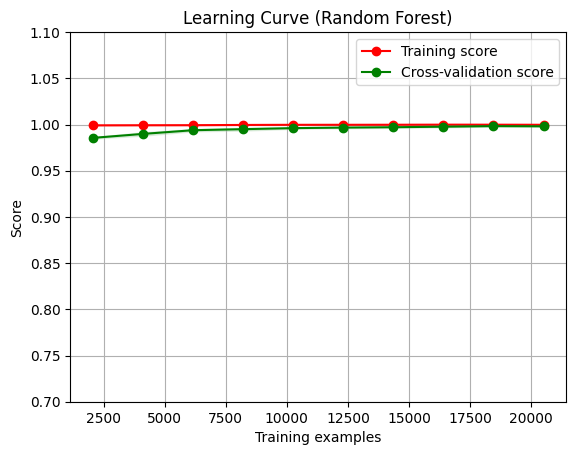

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(est_model_rf, x_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.7, 1.1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [25, 50, 100],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_dist,
                                   n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42)

random_search.fit(x_train, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")
best_model = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}


In [ ]:
train_score_best = best_model.score(x_train, y_train)
print(f"Ошибка на тренировочной выборке с лучшей моделью: {train_score_best:.4f}")

cv_train_scores_best = cross_val_score(best_model, x_train, y_train, cv=10)
print(f"Ошибки кросс-валидации на тренировочной выборке с лучшей моделью: {cv_train_scores_best}")
print(f"Лучшая оценка кросс-валидации на тренировочной выборке с лучшей моделью: {cv_train_scores_best.max():.4f}")

cv_test_scores_best = cross_val_score(best_model, x_test, y_test, cv=10)
print(f"Ошибки кросс-валидации на тестовой выборке с лучшей моделью: {cv_test_scores_best}")
print(f"Лучшая оценка кросс-валидации на тестовой выборке с лучшей моделью: {cv_test_scores_best.max():.4f}")

Ошибка на тренировочной выборке с лучшей моделью: 1.0000
Ошибки кросс-валидации на тренировочной выборке с лучшей моделью: [0.99843994 0.99765991 0.99960998 0.99921997 0.99882995 0.99882995
 0.99882995 0.99882995 0.99882995 0.99882995]
Лучшая оценка кросс-валидации на тренировочной выборке с лучшей моделью: 0.9996
Ошибки кросс-валидации на тестовой выборке с лучшей моделью: [0.99688474 0.99531981 0.99219969 0.99375975 0.99219969 0.99219969
 0.98283931 1.         0.99687988 0.99531981]
Лучшая оценка кросс-валидации на тестовой выборке с лучшей моделью: 1.0000


В этой работе мы решили проблему с помощью классической модели бинарной классификации. Мы добавили в наш набор данных дополнительный столбец под названием «in_playlist», который является бинарным: 0 означает, что трека нет в плейлисте, а 1 - что трек присутствует в плейлисте. Для классификации треков мы использовали Logistic Regression, RandomForest, Gradient Boosting, метод k-ближайших соседей. Мы разделили набор данных на train/test и провели до 10-кратных перекрестных проверок для каждой из моделей. Мы получили значения ошибки R2 и сравнили их. Результаты перекрестной валидации использовались для проверки сгенерированных ошибок. Также мы использовали перекрестную валидацию, чтобы получить оптимальное количество соседей для нашей модели K-NN.
В целом, после сравнения мы обнаружили, что Random Forest имеет точность ~0,99 на тестовом наборе, что делает ее выдающейся моделью.